In [1]:
DATA_DIR = "../semantic_gen/data/Home/home_before"

In [15]:
import torch
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns



In [3]:
from semantic_gen.datasets.clip import OpenCLIPNetwork, OpenCLIPNetworkConfig

clip = OpenCLIPNetwork(OpenCLIPNetworkConfig)

/scratch/jqm9ba/envs/gsplat-cuda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
FEATURE_QUERY = "water bottle"

In [89]:
trainset_dir = os.path.join(DATA_DIR, 'trainset')
tensor_files = [f for f in os.listdir(trainset_dir) if f.endswith('.pt')]
tensor_path = random.choice(tensor_files)

data = torch.load(os.path.join(trainset_dir, tensor_path))

K = data["K"]
camtoworld = data["camtoworld"]
image_with_features = data["image"]
image_id = data["image_id"]
point_feature = data["point_feature"]

rgb_image = image_with_features[..., :3]
image_features = image_with_features[..., 3:].to("cuda")

image_np = rgb_image.squeeze(0).cpu().numpy() / 255.0

In [90]:
tok_phrase = clip.tokenizer(FEATURE_QUERY).to("cuda")
feature_embeds = clip.model.encode_text(tok_phrase)  # [1, 512]
feature_embeds /= feature_embeds.norm(dim=-1, keepdim=True)
feature_embeds = feature_embeds.view(1, 1, 1, 512)
cosine_similarity = F.cosine_similarity(image_features, feature_embeds, dim=-1)
cosine_similarity_np = cosine_similarity.squeeze(0).cpu().detach().numpy()

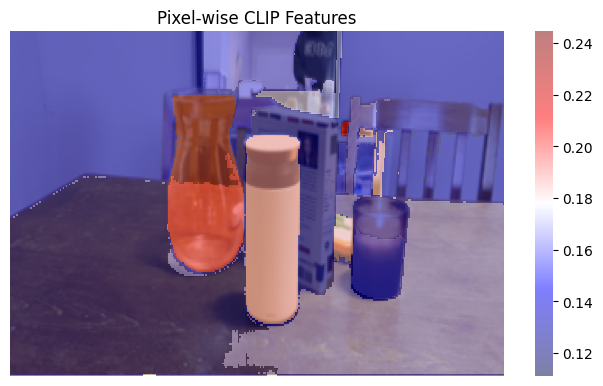

In [91]:
image_height, image_width, _ = image_np.shape
plt.figure(figsize=(image_width / 40, image_height / 40))
plt.imshow(image_np, aspect='auto')
sns.heatmap(cosine_similarity_np, cmap='seismic', alpha=0.5, ax=plt.gca(), cbar=True)  
plt.title('Pixel-wise CLIP Features')
plt.axis('off')
plt.show()

## Batch Eval

In [111]:
FEATURE_QUERY = "vase"
NUM_ENTRIES = 3

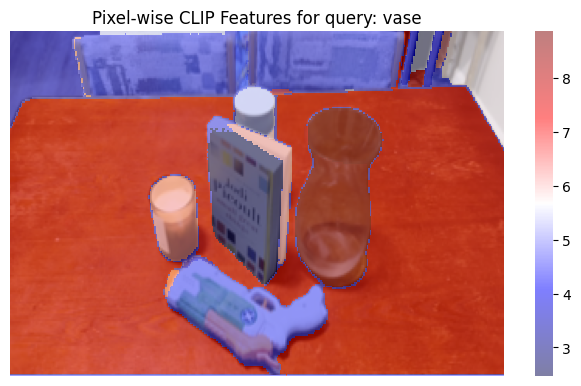

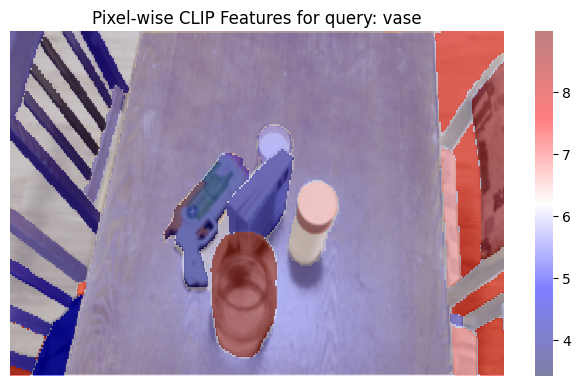

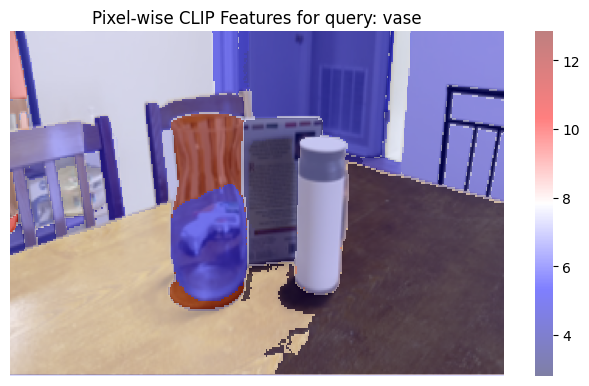

In [112]:
trainset_dir = os.path.join(DATA_DIR, 'trainset')
tensor_files = [f for f in os.listdir(trainset_dir) if f.endswith('.pt')]
tensor_paths = random.sample(tensor_files, NUM_ENTRIES)

for tensor_path in tensor_paths:
    data = torch.load(os.path.join(trainset_dir, tensor_path))

    K = data["K"]
    camtoworld = data["camtoworld"]
    image_with_features = data["image"]
    image_id = data["image_id"]
    point_feature = data["point_feature"]

    rgb_image = image_with_features[..., :3]
    image_features = image_with_features[..., 3:].to("cuda")

    image_np = rgb_image.squeeze(0).cpu().numpy() / 255.0

    tok_phrase = clip.tokenizer(FEATURE_QUERY).to("cuda")
    feature_embeds = clip.model.encode_text(tok_phrase)  # [1, 512]
    feature_embeds /= feature_embeds.norm(dim=-1, keepdim=True)
    feature_embeds = feature_embeds.view(1, 1, 1, 512)
    cosine_similarity = F.cosine_similarity(image_features, feature_embeds, dim=-1)
    cosine_similarity_np = cosine_similarity.squeeze(0).cpu().detach().numpy()
    cosine_similarity_np = np.exp(cosine_similarity_np * 10)


    image_height, image_width, _ = image_np.shape
    plt.figure(figsize=(image_width / 40, image_height / 40))
    plt.imshow(image_np, aspect='auto')
    sns.heatmap(cosine_similarity_np, cmap='seismic', alpha=0.5, ax=plt.gca(), cbar=True)  
    plt.title(f'Pixel-wise CLIP Features for query: {FEATURE_QUERY}')
    plt.axis('off')
    plt.show()